# Install Transformers Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 48.8 MB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 36.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import csv
import matplotlib.pyplot as plt

# specify GPU
device = torch.device("cuda")

# Split train dataset into train, validation and test sets (Non avviare)

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/reviewCleaned.csv")
train_text, val_text, train_labels, val_labels = train_test_split(df['Contenuto'], df['Classe'], 
                                                                    random_state=2018, 
                                                                    test_size=0.10, 
                                                                    stratify=df['Classe']) #split test 10%


with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Train.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['Commento', 'Classe'])
  for x in train_text.index:
    writer.writerow([train_text[x],train_labels[x]])

with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Val.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['Commento', 'Classe'])
  for x in val_text.index:
    writer.writerow([val_text[x],val_labels[x]])

# Load test, train and val


In [ ]:
train_t = []
train_l = [] 
df = pd.read_csv("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Train.csv")
for i in range(0,len(df)):
  train_t.append(df['Commento'][i])
  train_l.append(df['Classe'][i])

train_text = pd.Series(train_t)
train_labels = pd.Series(train_l)


test_t = []
test_l = [] 
df = pd.read_csv("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Test.csv")
for i in range(0,len(df)):
  test_t.append(df['Commento'][i])
  test_l.append(df['Classe'][i])

test_text = pd.Series(test_t)
test_labels = pd.Series(test_l)

val_t = []
val_l = [] 
df = pd.read_csv("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Val.csv")
for i in range(0,len(df)):
  val_t.append(df['Commento'][i])
  val_l.append(df['Classe'][i])

val_text = pd.Series(val_t)
val_labels = pd.Series(val_l)


In [ ]:
from collections import Counter
df = pd.read_csv("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/reviewCleaned.csv")
print(Counter(val_labels))
print(Counter(train_labels))
print(Counter(test_labels))
print(Counter(df["Classe"]))
print(len(df))

Counter({0: 1076, 1: 86})
Counter({0: 9683, 1: 774})
Counter({0: 36, 1: 26})
Counter({0: 10759, 1: 860})
11619


# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('dbmdz/bert-base-italian-xxl-cased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('dbmdz/bert-base-italian-xxl-cased')

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["questo è un tutorial modello bert", "metteremo a punto un modello bert"]

# encode text
sent_id = tokenizer.encode(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)
print(tokenizer.convert_ids_to_tokens(sent_id))

[102, 395, 198, 141, 241, 7090, 30883, 3224, 7065, 30881, 103, 3234, 185, 111, 1122, 141, 3224, 7065, 30881, 103]
['[CLS]', 'questo', 'è', 'un', 'tu', '##toria', '##l', 'modello', 'ber', '##t', '[SEP]', 'mettere', '##mo', 'a', 'punto', 'un', 'modello', 'ber', '##t', '[SEP]']


# Tokenization

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

count = 0
for x in seq_len:
  count = count + x
print(count/len(seq_len))

NameError: ignored

In [ ]:
max_seq_len = 40

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.values.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = None
train_sampler = None
train_dataloader = None
val_data = None
val_sampler = None
val_dataloader = None

def data_loader(batch_size):
  global train_data
  global train_sampler 
  global train_dataloader
  global val_data
  global val_sampler 
  global val_dataloader 

  # wrap tensors
  train_data = TensorDataset(train_seq, train_mask, train_y)

  # sampler for sampling the data during training
  train_sampler = RandomSampler(train_data)

  # dataLoader for train set
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # wrap tensors
  val_data = TensorDataset(val_seq, val_mask, val_y)

  # sampler for sampling the data during training
  val_sampler = SequentialSampler(val_data)

  # dataLoader for validation set
  val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from transformers import AdamW

#compute the class weights
class_wts = compute_class_weight(class_weight = "balanced",
                                 classes = np.unique(train_labels),
                                  y = train_labels)
print(class_wts)

[0.53996695 6.75516796]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# Fine-Tune BERT

In [ ]:
# function to train the model
def train(learning):

  # define the optimizer
  optimizer = AdamW(model.parameters(), lr = learning)

  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training


 Epoch 1 / 5
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.244
Validation Loss: 1.350


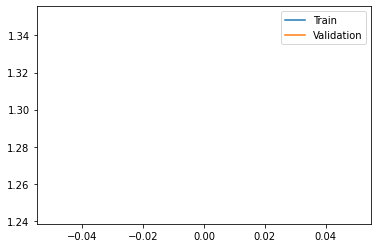


 Epoch 2 / 5
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.298
Validation Loss: 1.094


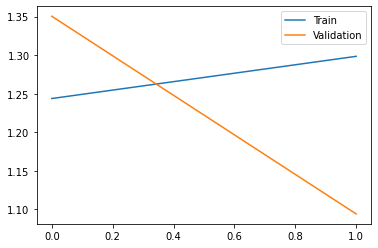


 Epoch 3 / 5
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.284
Validation Loss: 1.341


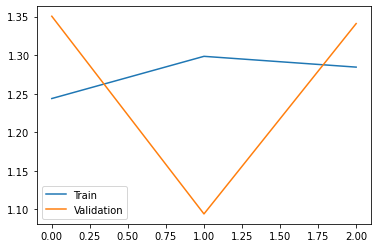


 Epoch 4 / 5
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.255
Validation Loss: 1.472


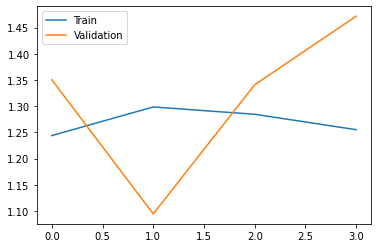


 Epoch 5 / 5
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.256
Validation Loss: 1.331


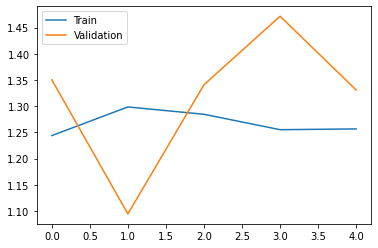


 Epoch 1 / 5
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.875
Validation Loss: 0.552


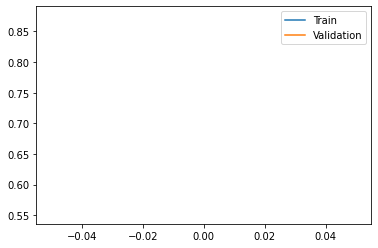


 Epoch 2 / 5
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.853
Validation Loss: 0.610


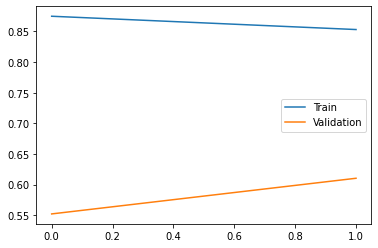


 Epoch 3 / 5
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.786
Validation Loss: 0.586


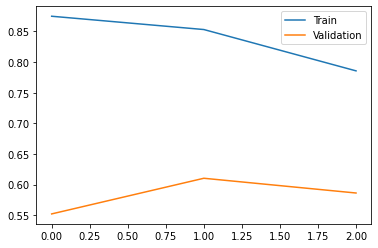


 Epoch 4 / 5
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.749
Validation Loss: 0.575


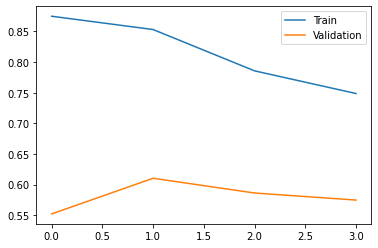


 Epoch 5 / 5
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.806
Validation Loss: 0.587


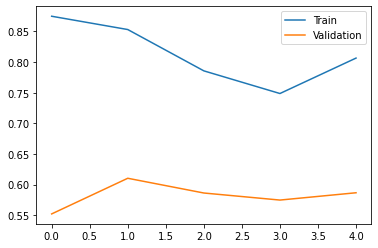


 Epoch 1 / 5
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.873
Validation Loss: 0.583


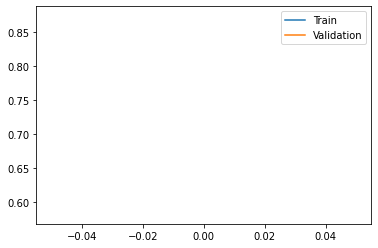


 Epoch 2 / 5
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.817
Validation Loss: 0.566


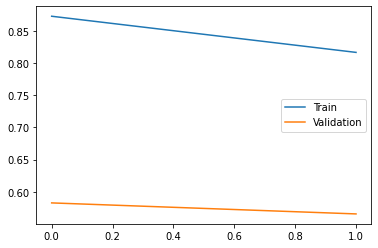


 Epoch 3 / 5
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.837
Validation Loss: 0.583


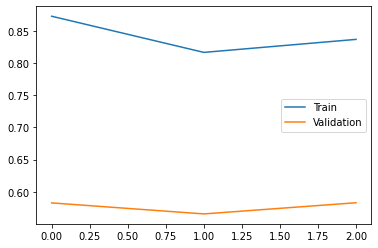


 Epoch 4 / 5
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.814
Validation Loss: 0.614


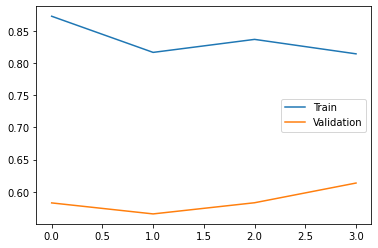


 Epoch 5 / 5
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.944
Validation Loss: 0.595


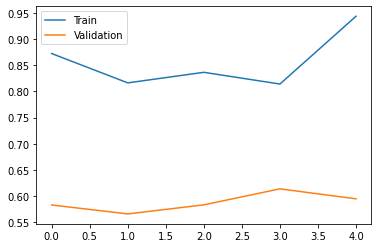


 Epoch 1 / 5
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.833
Validation Loss: 0.578


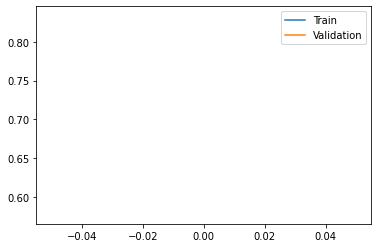


 Epoch 2 / 5
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.772
Validation Loss: 0.565


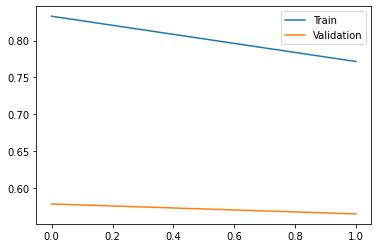


 Epoch 3 / 5
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.783
Validation Loss: 0.582


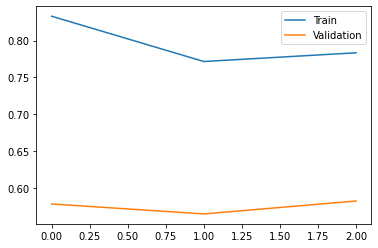


 Epoch 4 / 5
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.830
Validation Loss: 0.570


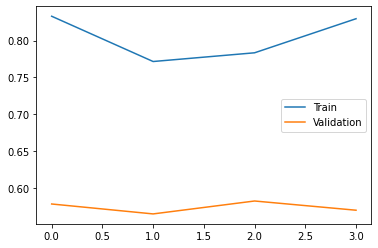


 Epoch 5 / 5
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.785
Validation Loss: 0.569


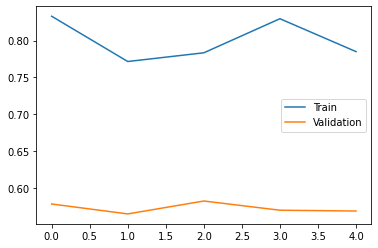


 Epoch 1 / 5
  Batch    50  of     82.

Evaluating...

Training Loss: 0.828
Validation Loss: 0.582


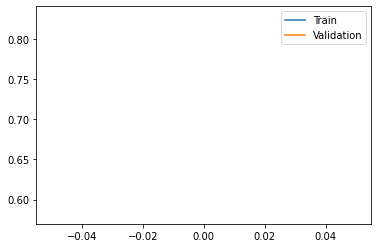


 Epoch 2 / 5
  Batch    50  of     82.

Evaluating...

Training Loss: 0.853
Validation Loss: 0.575


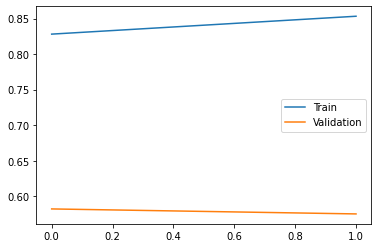


 Epoch 3 / 5
  Batch    50  of     82.

Evaluating...

Training Loss: 0.830
Validation Loss: 0.577


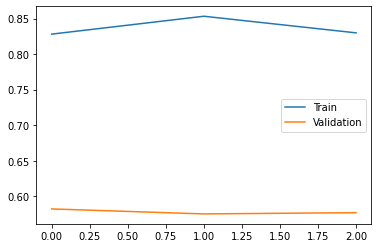


 Epoch 4 / 5
  Batch    50  of     82.

Evaluating...

Training Loss: 0.803
Validation Loss: 0.577


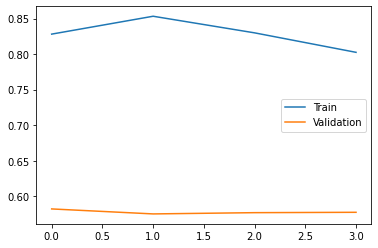


 Epoch 5 / 5
  Batch    50  of     82.

Evaluating...

Training Loss: 0.814
Validation Loss: 0.569


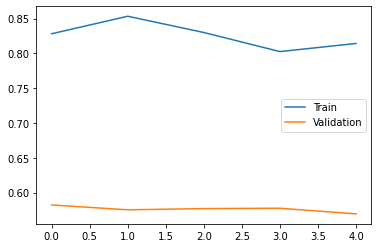


 Epoch 1 / 5

Evaluating...

Training Loss: 0.858
Validation Loss: 0.585


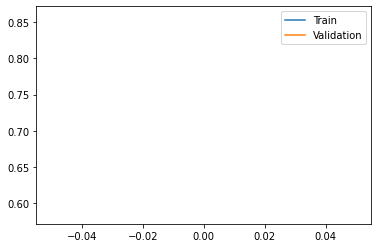


 Epoch 2 / 5

Evaluating...

Training Loss: 0.765
Validation Loss: 0.586


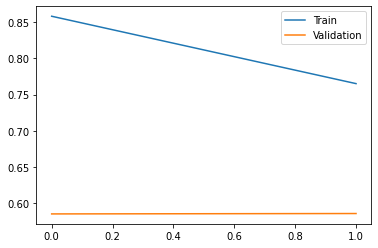


 Epoch 3 / 5

Evaluating...

Training Loss: 0.775
Validation Loss: 0.582


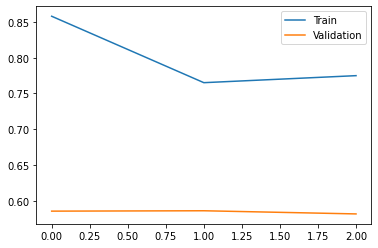


 Epoch 4 / 5

Evaluating...

Training Loss: 0.730
Validation Loss: 0.580


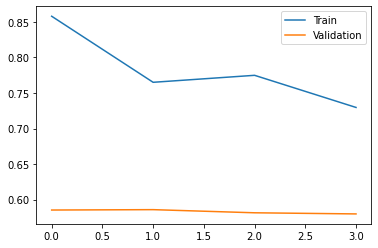


 Epoch 5 / 5

Evaluating...

Training Loss: 0.808
Validation Loss: 0.581


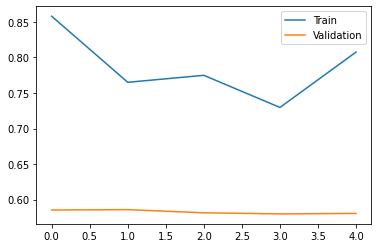


 Epoch 1 / 10
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.111
Validation Loss: 1.476


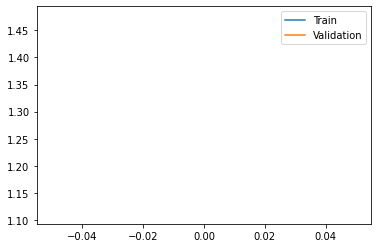


 Epoch 2 / 10
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.304
Validation Loss: 1.819


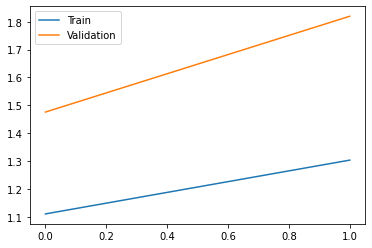


 Epoch 3 / 10
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.321
Validation Loss: 1.535


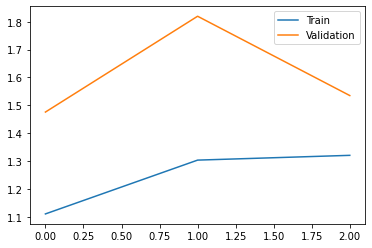


 Epoch 4 / 10
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.287
Validation Loss: 1.461


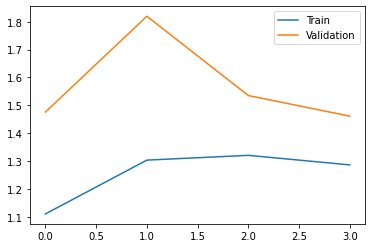


 Epoch 5 / 10
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.290
Validation Loss: 1.301


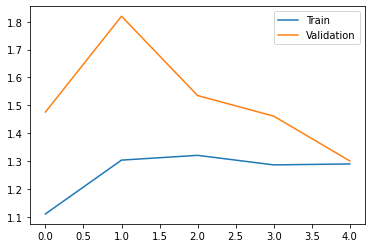


 Epoch 6 / 10
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.246
Validation Loss: 1.219


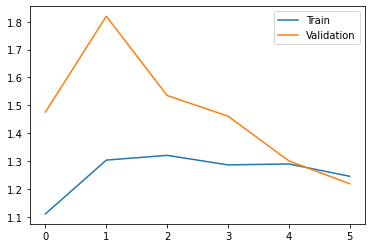


 Epoch 7 / 10
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.220
Validation Loss: 1.717


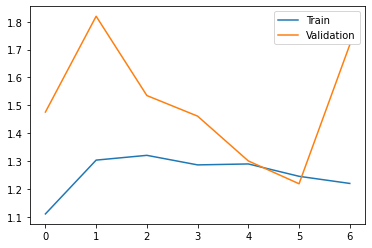


 Epoch 8 / 10
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.267
Validation Loss: 1.349


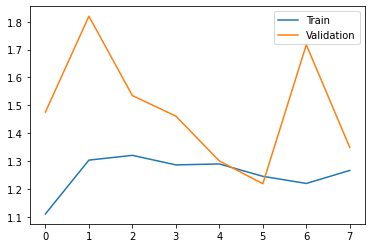


 Epoch 9 / 10
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.235
Validation Loss: 1.490


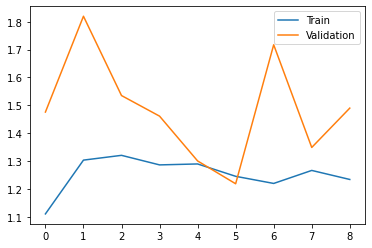


 Epoch 10 / 10
  Batch    50  of  1,308.
  Batch   100  of  1,308.
  Batch   150  of  1,308.
  Batch   200  of  1,308.
  Batch   250  of  1,308.
  Batch   300  of  1,308.
  Batch   350  of  1,308.
  Batch   400  of  1,308.
  Batch   450  of  1,308.
  Batch   500  of  1,308.
  Batch   550  of  1,308.
  Batch   600  of  1,308.
  Batch   650  of  1,308.
  Batch   700  of  1,308.
  Batch   750  of  1,308.
  Batch   800  of  1,308.
  Batch   850  of  1,308.
  Batch   900  of  1,308.
  Batch   950  of  1,308.
  Batch 1,000  of  1,308.
  Batch 1,050  of  1,308.
  Batch 1,100  of  1,308.
  Batch 1,150  of  1,308.
  Batch 1,200  of  1,308.
  Batch 1,250  of  1,308.
  Batch 1,300  of  1,308.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 1.245
Validation Loss: 0.987


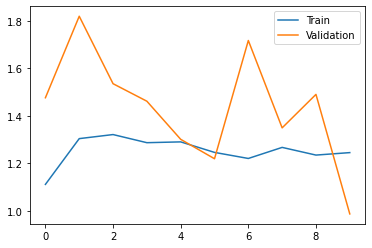


 Epoch 1 / 10
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.909
Validation Loss: 0.595


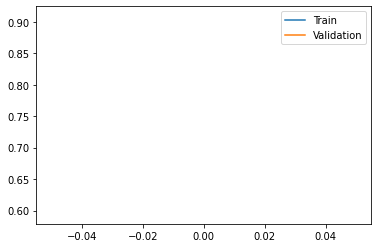


 Epoch 2 / 10
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.750
Validation Loss: 0.591


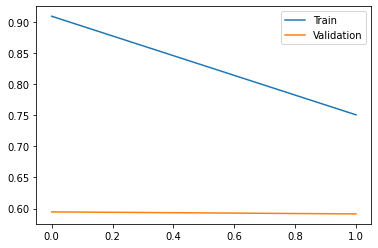


 Epoch 3 / 10
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.836
Validation Loss: 0.587


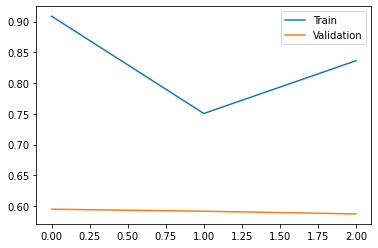


 Epoch 4 / 10
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.815
Validation Loss: 0.612


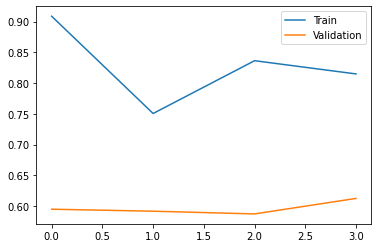


 Epoch 5 / 10
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.723
Validation Loss: 0.581


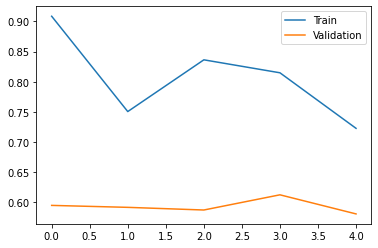


 Epoch 6 / 10
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.783
Validation Loss: 0.606


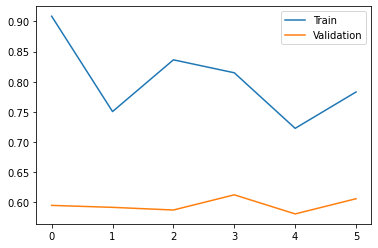


 Epoch 7 / 10
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.862
Validation Loss: 0.610


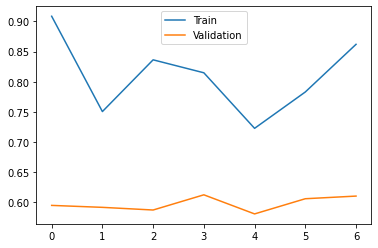


 Epoch 8 / 10
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.789
Validation Loss: 0.601


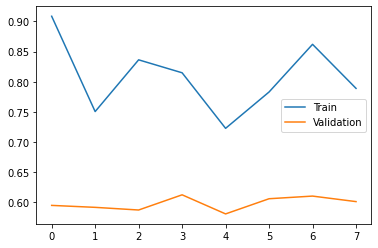


 Epoch 9 / 10
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.781
Validation Loss: 0.577


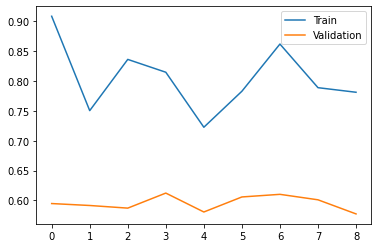


 Epoch 10 / 10
  Batch    50  of    654.
  Batch   100  of    654.
  Batch   150  of    654.
  Batch   200  of    654.
  Batch   250  of    654.
  Batch   300  of    654.
  Batch   350  of    654.
  Batch   400  of    654.
  Batch   450  of    654.
  Batch   500  of    654.
  Batch   550  of    654.
  Batch   600  of    654.
  Batch   650  of    654.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.810
Validation Loss: 0.615


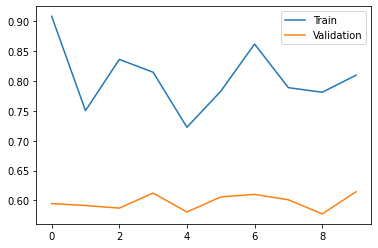


 Epoch 1 / 10
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.852
Validation Loss: 0.585


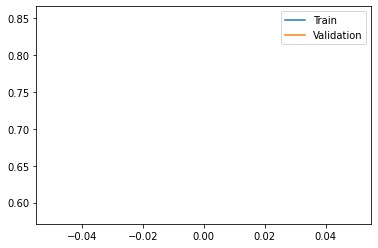


 Epoch 2 / 10
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.715
Validation Loss: 0.580


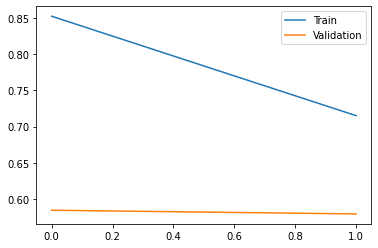


 Epoch 3 / 10
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.858
Validation Loss: 0.600


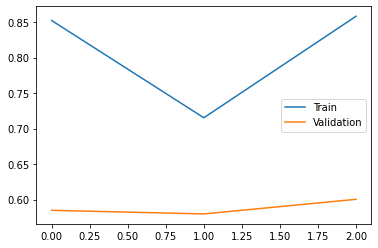


 Epoch 4 / 10
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.729
Validation Loss: 0.594


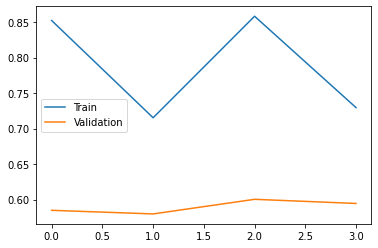


 Epoch 5 / 10
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.871
Validation Loss: 0.595


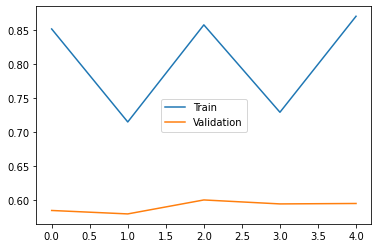


 Epoch 6 / 10
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.831
Validation Loss: 0.572


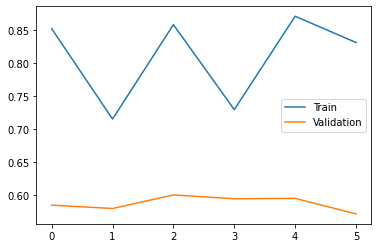


 Epoch 7 / 10
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.900
Validation Loss: 0.576


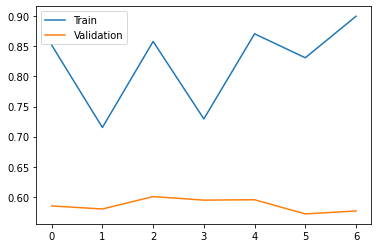


 Epoch 8 / 10
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.796
Validation Loss: 0.578


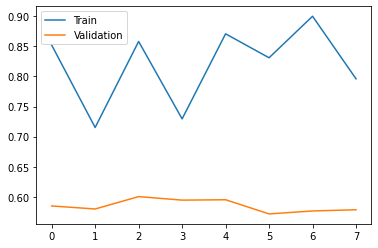


 Epoch 9 / 10
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.869
Validation Loss: 0.587


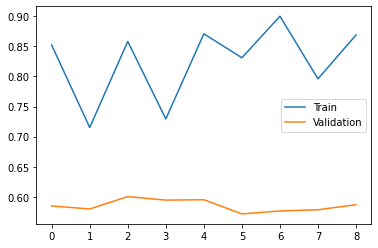


 Epoch 10 / 10
  Batch    50  of    327.
  Batch   100  of    327.
  Batch   150  of    327.
  Batch   200  of    327.
  Batch   250  of    327.
  Batch   300  of    327.

Evaluating...

Training Loss: 0.767
Validation Loss: 0.585


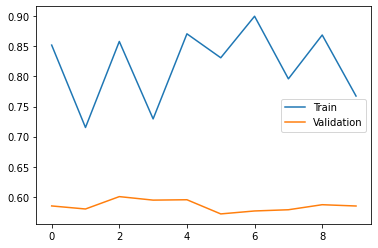


 Epoch 1 / 10
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.962
Validation Loss: 0.591


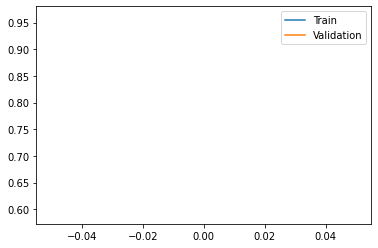


 Epoch 2 / 10
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.768
Validation Loss: 0.593


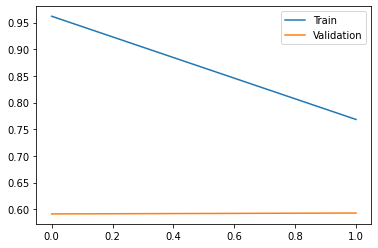


 Epoch 3 / 10
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.799
Validation Loss: 0.585


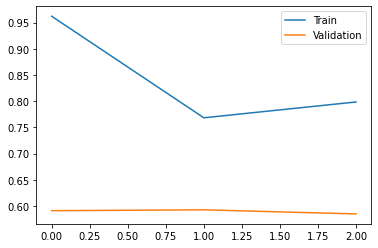


 Epoch 4 / 10
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.811
Validation Loss: 0.575


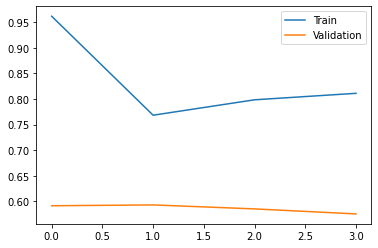


 Epoch 5 / 10
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.777
Validation Loss: 0.581


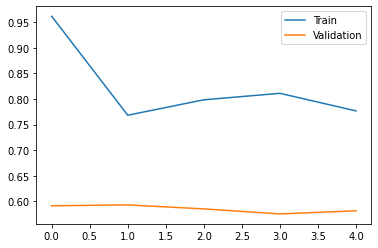


 Epoch 6 / 10
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.748
Validation Loss: 0.584


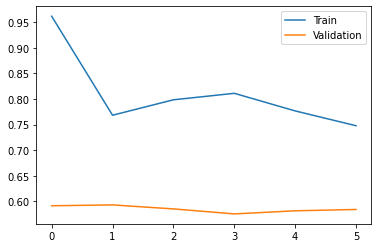


 Epoch 7 / 10
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.868
Validation Loss: 0.596


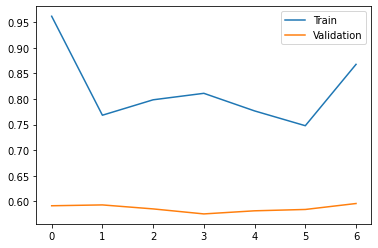


 Epoch 8 / 10
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.750
Validation Loss: 0.586


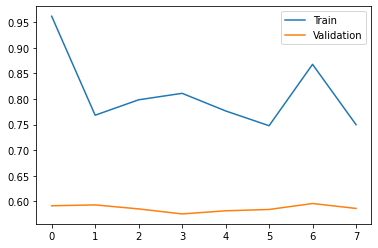


 Epoch 9 / 10
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.738
Validation Loss: 0.584


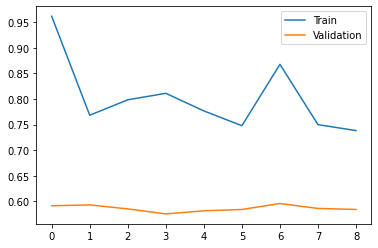


 Epoch 10 / 10
  Batch    50  of    164.
  Batch   100  of    164.
  Batch   150  of    164.

Evaluating...

Training Loss: 0.767
Validation Loss: 0.585


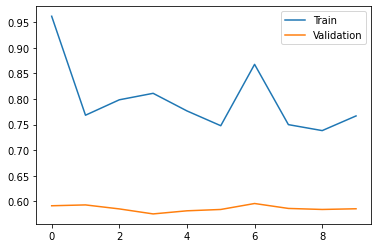

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/ModelDate.csv")

for x in range(0,10):

  data_loader(int(df["Batch_size"][x]))

  # set initial loss to infinite
  best_valid_loss = float('inf')

  # empty lists to store training and validation loss of each epoch
  train_losses=[]
  valid_losses=[]

  #for each epoch
  epochs = int(df["Epoche"][x])
  for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train(float(df["Learning_rate"][x]))
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Modelli/Modelli_con_loss_function_25_con_val_10/saved_weights'+str(x)+'.pt')
    
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    
    plt.plot(train_losses, label = "Train")
    plt.plot(valid_losses, label = "Validation")
    plt.legend()
    plt.savefig('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Modelli/Modelli_con_loss_function_25_con_val_10/Plot'+str(x)+'.png')
    plt.show()

# Get Predictions for Test Data

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

accuracys = []
precisions_nfake = []
precisions_fake = []
recalls_nfake = []
recalls_fake = []
fscores_nfake = []
fscores_fake = []

df = pd.read_csv("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/ModelDate.csv")
for x in range(0,len(df)):

  print(x)

  #load weights of best model
  path = '/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Modelli/Modelli_40/saved_weights'+str(x)+'.pt'
  model.load_state_dict(torch.load(path))

  # get predictions for test data
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
  
  # model's performance
  preds = np.argmax(preds, axis = 1)
  report = classification_report(test_y, preds, output_dict=True)
  accuracys.append(str(round(accuracy_score(test_y, preds),2)))
  precisions_nfake.append(str(round(report['0']['precision'],2)))
  precisions_fake.append(str(round(report['1']['precision'],2)))
  recalls_nfake.append(str(round(report['0']['recall'],2)))
  recalls_fake.append(str(round(report['1']['recall'],2)))
  fscores_nfake.append(str(round(report['0']['f1-score'],2)))
  fscores_fake.append(str(round(report['1']['f1-score'],2)))

  # confusion matrix
  pd.crosstab(test_y, preds)

  
with open('/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Modelli/Modelli_40/ResultsModel.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['Learning_rate','Epoche','Batch_size','Accuracy','Precision_0','Precision_1','Recall_0','Recall_1', 'F-score_0','F-score_1'])
  for x in range(0,len(df)):
    writer.writerow([df['Learning_rate'][x],df['Epoche'][x],df['Batch_size'][x], accuracys[x],precisions_nfake[x],precisions_fake[x],recalls_nfake[x],recalls_fake[x],fscores_nfake[x],fscores_fake[x],])


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

#Avviare fino a bert tranne tranne lo split e caricamento dati

Testo_recensione = "Ciao" #@param {type:"string"}

test_t = [Testo_recensione]
test_l = [0] 

test_text = pd.Series(test_t)
test_labels = pd.Series(test_l)

max_seq_len = 40

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

df = pd.read_csv("/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Modelli/Modelli_con_loss_function_40_con_val_10/ResultsModel.csv")
for x in range(0,len(df)):

  print("Modello: " + str(x))
  #print(df["Accuracy"][x])

  #load weights of best model
  path = '/content/drive/Shareddrives/Intelligenza Artificiale/Progetto/Modelli/Modelli_con_loss_function_40_con_val_10/saved_weights'+str(x)+'.pt'
  model.load_state_dict(torch.load(path))

  # get predictions for test data
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu()

  m = nn.Softmax(dim=1)
  output = m(preds)
  # model's performance
  print("probabilità 0:",output.numpy()[0][0])
  print("probabilità 1:",output.numpy()[0][1])
  preds = np.argmax(preds, axis = 1)
  print("predizione:",preds.numpy()[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Modello: 0
probabilità 0: 0.9998036
probabilità 1: 0.00019640276
predizione: 0
Modello: 1
probabilità 0: 0.9999989
probabilità 1: 1.103767e-06
predizione: 0
Modello: 2
probabilità 0: 0.99982065
probabilità 1: 0.00017932129
predizione: 0
Modello: 3
probabilità 0: 0.99998736
probabilità 1: 1.2679629e-05
predizione: 0
Modello: 4


KeyboardInterrupt: ignored